In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['cropped-car-image', 'resnet-weight', '2019-3rd-ml-month-with-kakr']


# 허태명님과 김태진님의 커널을 참고했습니다
https://www.kaggle.com/tmheo74/3rd-ml-month-car-image-cropping

https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline/data#3rd-ML-Month---Car-Model-Classification-

In [2]:
print(os.listdir("../input/cropped-car-image"))

['test_crop', 'train_crop']


In [3]:
COMPETITION_DATA_PATH = '../input/2019-3rd-ml-month-with-kakr'
IMAGE_DATA_PATH = '../input/cropped-car-image'

# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(IMAGE_DATA_PATH, 'train_crop')
TEST_IMG_PATH = os.path.join(IMAGE_DATA_PATH, 'test_crop')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(COMPETITION_DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(COMPETITION_DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(COMPETITION_DATA_PATH, 'class.csv'))

In [4]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [5]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [6]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [7]:
# 트레이닝, 테스팅 이미지갯수를 확인하겠습니다
print(len(os.listdir(TRAIN_IMG_PATH)))
print(len(os.listdir(TEST_IMG_PATH)))

10016
6169


In [8]:
# 클래스 갯수를 확인합니다
print(df_class.shape[0])

196


In [9]:
# 이미지들을 구경해 보겠습니다
from PIL import Image, ImageDraw

filenames = df_train.img_file[16:20]
filenames.head()

16    train_00017.jpg
17    train_00018.jpg
18    train_00019.jpg
19    train_00020.jpg
Name: img_file, dtype: object

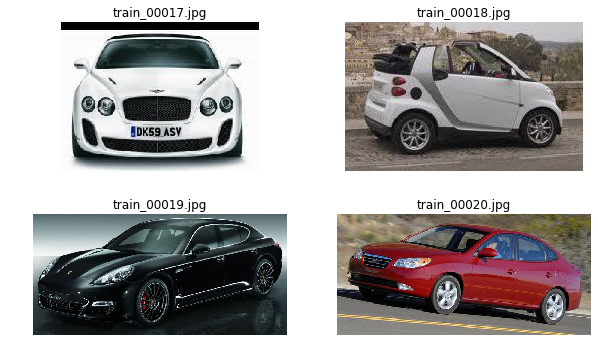

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for index, filename in enumerate(filenames):
    img = Image.open(TRAIN_IMG_PATH + '/' + filename)
    plt.subplot(2,2,index+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)

In [11]:
# 사진이 찍힌 각도도 많이 다르고, 조명, 기울기, 등등 다른요소들이 많네요

In [12]:
# 모델링
from sklearn.model_selection import train_test_split

df_train['class'] = df_train['class'].astype('str')

# bounding box 컬럼들을 제거해줍니다
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

df_test.head(1)

,img_file
0,test_00001.jpg


In [13]:
df_train.head(1)

,img_file,class
0,train_00001.jpg,108


In [14]:
index_list = np.arange(df_train.shape[0])
print(index_list)

[    0     1     2 ... 10013 10014 10015]


In [15]:
# 이번 대회는 micro f1 score 를 기준으로 평가되기때문에 몇몇 클래스에서만 좋은 정확도를 내는것보다 모든 클래스에서 골고루 높은 정확도를 내는게
# 점수가 더 높을거 같네요.
# 트레이닝 데이터셋에 클래스분포를보고 그에맞춰서 training/validation 데이타셋으로 나눠주는게 좋을거같아요.

df_train['class'].value_counts().head()

119    84
79     60
167    59
161    59
144    57
Name: class, dtype: int64

In [16]:
class_labels = list(df_train['class'])

In [17]:
# applying stratification
train_idx, val_idx = train_test_split(index_list, stratify=class_labels, train_size=0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(8012, 2)
(2004, 2)
(6169, 1)


In [18]:
X_train.head()

,img_file,class
3058,train_03059.jpg,79
1240,train_01241.jpg,78
9584,train_09585.jpg,3
6642,train_06643.jpg,153
7442,train_07443.jpg,66


In [19]:
X_train['class'].value_counts().head()

119    67
79     48
161    47
167    47
182    46
Name: class, dtype: int64

In [20]:
X_val['class'].value_counts().head()

119    17
167    12
79     12
161    12
123    11
Name: class, dtype: int64

In [21]:
# Image Generator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [22]:
# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = False,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.10,
    rotation_range = 20,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory= TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_IMG_PATH,
    x_col = 'img_file',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.
Found 6169 validated image filenames.


In [23]:
# loading pretrained model
resnet_model = ResNet50(include_top=False, input_shape=(224,224,3))

from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax'))
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
model.load_weights('../input/resnet-weight/resnet_model_0.87_0.5693.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


In [28]:
# freezing the resnet 50
for layer in model.layers[0].layers:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 401,604
Non-trainable params: 23,587,712
_________________________________________________________________


In [34]:
from keras.models import Model

new_model = Model(model.inputs, model.layers[-2].output)  # assuming you want the 3rd layer from the last

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
new_sequential_model = Sequential()
for layer in new_model.layers:
    new_sequential_model.add(layer)

new_sequential_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [40]:
new_sequential_model.add(Dense(1024, activation='relu'))
new_sequential_model.add(Dropout(0.5))
new_sequential_model.add(Dense(196, activation='softmax'))
new_sequential_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               200900    
Total params: 25,886,788
Trainable params: 2,299,076
Non-trainable params: 23,587,712
_________________________________________________________________


In [41]:
model = new_sequential_model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               200900    
Total params: 25,886,788
Trainable params: 2,299,076
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
from keras import optimizers

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

# optimizer = optimizers.RMSprop(lr=0.00025, rho=0.9, epsilon=None, decay=0.0)

# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
import gc

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size
    
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [ckpt, es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=20,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/20
251/251 [==============================] - 122s 485ms/step - loss: 4.2720 - acc: 0.2822 - val_loss: 1.1792 - val_acc: 0.6946

Epoch 00001: val_acc improved from -inf to 0.69461, saving model to resnet_model_0.69_1.1792.h5
Epoch 2/20
251/251 [==============================] - 114s 453ms/step - loss: 1.3060 - acc: 0.6333 - val_loss: 0.7925 - val_acc: 0.7854

Epoch 00002: val_acc improved from 0.69461 to 0.78543, saving model to resnet_model_0.79_0.7925.h5
Epoch 3/20
251/251 [==============================] - 114s 455ms/step - loss: 0.8791 - acc: 0.7435 - val_loss: 0.7098 - val_acc: 0.8004

Epoch 00003: val_acc improved from 0.78543 to 0.80040, saving model to resnet_model_0.80_0.7098.h5
Epoch 4/20
251/251 [==============================] - 114s 453ms/step - loss: 0.6993 - acc: 0.7895 - val_loss: 0.6593 - val_acc: 0.8164

Epoch 00004: val_acc improved from 0.80040 to 0.81637, saving model to resnet_model_0.82_0.6593.h5
Epoch 5/20
251/251 [==============================] - 114s 

410

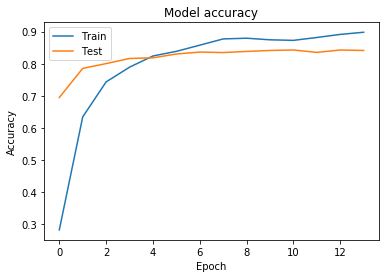

In [44]:
# Training History Visualization
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

# Model Predict

test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

In [ ]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv('../input/2019-3rd-ml-month-with-kakr/sample_submission.csv')
submission["class"] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()